In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


In [33]:
data = pd.read_csv("satcat.tsv", sep="\t", low_memory=False); data

,#JCAT,Satcat,Launch_Tag,Piece,Type,Name,PLName,LDate,Parent,SDate,...,ODate,Perigee,PF,Apogee,AF,Inc,IF,OpOrbit,OQUAL,AltNames
0,S00001,00001,1957 ALP,1957 ALP 1,R2,8K71PS No. M1-10 Stage 2,8K71A M1-10 (M1-1PS),1957 Oct 4,-,1957 Oct 4 1933,...,1957 Oct 4,214,,938,,65.10,,LLEO/I,-,-
1,S00002,00002,1957 ALP,1957 ALP 2,P,1-y ISZ,PS-1,1957 Oct 4,S00001,1957 Oct 4 1933,...,1957 Oct 4,214,,938,,65.10,,LLEO/I,-,":RE,:RC"
2,S00003,00003,1957 BET,1957 BET 1,P A,2-y ISZ,PS-2,1957 Nov 3,A00002,1957 Nov 3 0235,...,1957 Nov 3,211,,1659,,65.33,,LEO/I,-,":RE,:RC"
3,S00004,00004,1958 ALP,1958 ALP,P A,Explorer I,Explorer 1,1958 Feb 1,A00004,1958 Feb 1 0355,...,1958 Feb 1,359,,2542,,33.18,,LEO/I,-,":UA,:UB,DEAL I:IA"
4,S00005,00005,1958 BET,1958 BET 2,P,Vanguard I,Vanguard Test Satellite H,1958 Mar 17,S00016,1958 Mar 17 1224,...,1959 May 23,657,,3935,,34.25,,MEO,-,":UA,:VA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63020,S63021,63021,2025-032,2025-032S,P D,Starlink 32929,Starlink Group 12-8-17,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,2025 Feb 15,285,,291,,43.01,,LLEO/I,-,-
63021,S63022,63022,2025-032,2025-032T,P D,Starlink 32944,Starlink Group 12-8-18,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,2025 Feb 15,285,,291,,43.01,,LLEO/I,-,-
63022,S63023,63023,2025-032,2025-032U,P D,Starlink 32943,Starlink Group 12-8-19,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,2025 Feb 15,285,,291,,43.01,,LLEO/I,-,-
63023,S63024,63024,2025-032,2025-032V,P D,Starlink 32803,Starlink Group 12-8-20,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,2025 Feb 15,285,,291,,43.01,,LLEO/I,-,-


In [34]:

def identify_debris(data):
    # Byte positions are 0-indexed in Python
    debris_conditions = (
        (data['Type'].str[0].isin(['D'])) |  # First byte indicates debris
        ((data['Type'].str[0].isin(['C'])) & data['Type'].str[1:].apply(lambda x: any(sub in x for sub in ["B", "I", "J", "K", "P", "Q", "W", "Z", "F", "M", "T", "V", "G", "O", "X"])))  # Component debris
    ) & ~data['Status'].isin(["R"])  # Status indicating debris
    
    return data[debris_conditions]

    
def randomly_discard_same_perigee(data, discard_fraction=0.2):
    # Group by Perigee and apply the discard logic
    def discard_group(group):
        if len(group) > 1:  # Only discard if more than one satellite has the same perigee
            discard_count = int(len(group) * discard_fraction)
            group_to_discard = group.sample(n=discard_count, random_state=42)
            return group.drop(group_to_discard.index)
        return group
    
    # Exclude the grouping columns after applying groupby to avoid the DeprecationWarning
    return data.groupby('Perigee', group_keys=False).apply(discard_group)

def identify_active(data):
    debris_index = identify_debris(data).index
    active_conditions = ~data.index.isin(debris_index) & ~data['Status'].isin(["R"])
    return data[active_conditions]

data_t = data.copy()
data_t['Perigee'] = pd.to_numeric(data_t['Perigee'], errors='coerce')
data_t['Apogee'] = pd.to_numeric(data_t['Apogee'], errors='coerce')
data_t.loc[data_t['Perigee'] < 0, 'Perigee'] = np.nan
data_t.loc[data_t['Apogee'] < 0, 'Apogee'] = np.nan
data_t = data_t.dropna(subset=['Perigee', 'Apogee'])

data_t['average'] = (data_t['Perigee'] + data_t['Apogee']) / 2 

data_t = randomly_discard_same_perigee(data_t, discard_fraction=0.9555)


data_waste = identify_debris(data_t)
data_active = identify_active(data_t)


data_waste
data_active


C:\Users\gmahm\AppData\Local\Temp\ipykernel_16284\1537428144.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('Perigee', group_keys=False).apply(discard_group)


,#JCAT,Satcat,Launch_Tag,Piece,Type,Name,PLName,LDate,Parent,SDate,...,Perigee,PF,Apogee,AF,Inc,IF,OpOrbit,OQUAL,AltNames,average
62534,S62535,62535,2025-005,2025-005D,P D?m,USA 466,Starshield 6-04,2025 Jan 10,A11395,2025 Jan 10 0453?,...,0.0,,0.0,,0.00,,-,-,-,0.0
62547,S62548,62548,2025-005,2025-005S,P D?m,USA 479,Starshield 6-17,2025 Jan 10,A11395,2025 Jan 10 0453?,...,0.0,,0.0,,0.00,,-,-,-,0.0
3169,S03170,03170,1968-025,1968-025A,PP-H,Apollo 6,Apollo SC020,1968 Apr 4,S03171,1968 Apr 4 1514,...,33.0,,22533.0,,32.66,,TA,-,AS-502,11283.0
6300,S06301,06301,1972-096,1972-096B,R3 D,Saturn S-IVB-512,Saturn S-IVB-512,1972 Dec 7,R28258,1972 Dec 7 0544:42,...,68.0,,424169.0,,28.42,,CLO,-,-,212118.5
59276,S59277,59277,2024-051,2024-051B,R2 D,CZ-8 Y3 Stage 2,CZ-8 Stage 2,2024 Mar 20,R83116,2024 Mar 20 0041?,...,76.0,,373791.0,,23.02,,CLO,-,-,186933.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,S02764,02764,1967-035,1967-035B,R2 D,Centaur D AC-12,Centaur D AC-12,1967 Apr 17,R15927,1967 Apr 17 0714,...,172143.0,,351609.0,,19.50,?,CLO,-,-,261876.0
29509,S29510,29510,2006-047,2006-047A,P D,STEREO A,STEREO Ahead,2006 Oct 26,S29511,2006 Oct 26 0119,...,192937.0,,1772266.0,,33.10,,CLO,-,-,982601.5
6196,S06197,06197,1972-073,1972-073A,P D,IMP 7,IMP H,1972 Sep 23,S06203,1972 Sep 23 0138,...,201100.0,,235600.0,,17.20,,DSO,-,Explorer 47,218350.0
6892,S06893,06893,1973-078,1973-078A,P D,IMP 8,IMP J,1973 Oct 26,S06896,1973 Oct 26 0240,...,215092.0,,215092.0,,19.70,,DSO,-,Explorer 50,215092.0


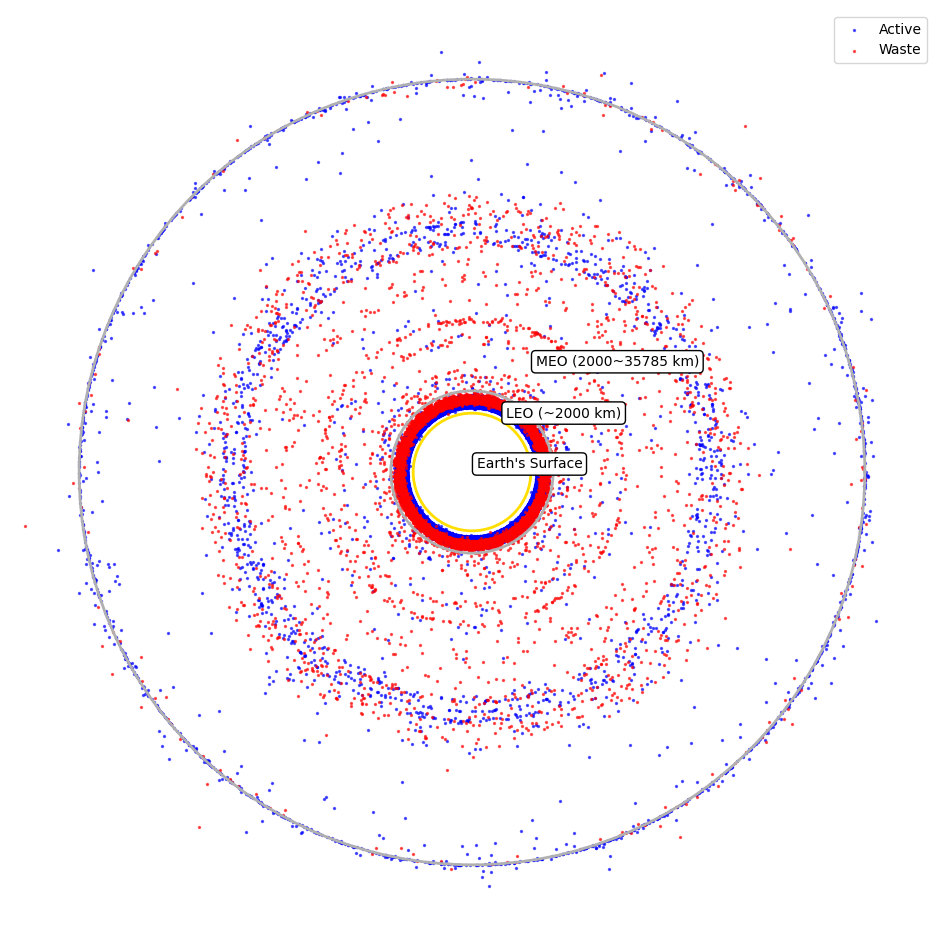

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
E_radius = 6800  # Approx. Earth radius in km

# Define radius (r) as the satellite's average altitude + Earth’s radius
r1 = data_waste['average'] + E_radius
r2 = data_active['average'] + E_radius
theta1 = np.random.uniform(0, 2 * np.pi, size=len(r1))
theta2 = np.random.uniform(0, 2 * np.pi, size=len(r2))

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12))
ax.set_rlim(0, 7000 + 5000)  # Radial limit
ax.spines['polar'].set_visible(False)

# Scatter satellite positions
ax.scatter(theta2, r2, s=2, alpha=0.6, color='blue', label="Active")
ax.scatter(theta1, r1, s=2, alpha=0.6, color='red', label="Waste")

# Hide angular grid lines
ax.grid(axis='x', visible=False)
ax.set_xticks([])

# Set radial ticks manually
ytick_vals = [0, 6378, 2000 + E_radius, 35785 + E_radius, 50085]
ax.set_yticks(ytick_vals)
ax.set_yticklabels(["", "", "", "", ""]) 

# Custom radial labels at an angle (e.g., 60 degrees)
labels = ["Earth's Surface", "LEO (~2000 km)", "MEO (2000~35785 km)", " ", " " ]
label_angle = np.deg2rad(60)

for r, label in zip(ytick_vals[:-2], labels):
    if label == "MEO (2000~35785 km)":
        offset = 5000 # Larger offset only for LEO
    else:
        offset = 1000
    ax.text(
        label_angle,
        r + offset,
        label,
        fontsize=10,
        ha='left',
        va='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Adjust label angle position
ax.set_rlabel_position(60)

# Style specific gridlines
ax.yaxis.get_gridlines()[0].set_linewidth(2)
ax.yaxis.get_gridlines()[1].set_color('#FFDE00')
ax.yaxis.get_gridlines()[1].set_linewidth(2)
ax.yaxis.get_gridlines()[2].set_linewidth(2)
ax.yaxis.get_gridlines()[3].set_linewidth(2)
ax.yaxis.get_gridlines()[4].set_linewidth(0)  # Hide the outermost line

# Add legend
ax.legend(loc='upper right')

plt.show()


In [36]:

def identify_debris(data):
    # Byte positions are 0-indexed in Python
    debris_conditions = (
        (data['Type'].str[0].isin(['D'])) |  # First byte indicates debris
        ((data['Type'].str[0].isin(['C'])) & data['Type'].str[1:].apply(lambda x: any(sub in x for sub in ["B", "I", "J", "K", "P", "Q", "W", "Z", "F", "M", "T", "V", "G", "O", "X"])))  # Component debris
    ) & ~data['Status'].isin(["R"])  # Status indicating debris
    
    return data[debris_conditions]

    
def randomly_discard_same_perigee(data, discard_fraction=0.2):
    # Group by Perigee and apply the discard logic
    def discard_group(group):
        if len(group) > 1:  # Only discard if more than one satellite has the same perigee
            discard_count = int(len(group) * discard_fraction)
            group_to_discard = group.sample(n=discard_count, random_state=42)
            return group.drop(group_to_discard.index)
        return group
    
    # Exclude the grouping columns after applying groupby to avoid the DeprecationWarning
    return data.groupby('Perigee', group_keys=False).apply(discard_group)

def identify_active(data):
    debris_index = identify_debris(data).index
    active_conditions = ~data.index.isin(debris_index) & ~data['Status'].isin(["R"])
    return data[active_conditions]

data_t = data.copy()
data_t['Perigee'] = pd.to_numeric(data_t['Perigee'], errors='coerce')
data_t['Apogee'] = pd.to_numeric(data_t['Apogee'], errors='coerce')
data_t.loc[data_t['Perigee'] < 0, 'Perigee'] = np.nan
data_t.loc[data_t['Apogee'] < 0, 'Apogee'] = np.nan
data_t = data_t.dropna(subset=['Perigee', 'Apogee'])

data_t['average'] = (data_t['Perigee'] + data_t['Apogee']) / 2 

# data_t = randomly_discard_same_perigee(data_t, discard_fraction=0.9555)


data_waste = identify_debris(data_t)
data_active = identify_active(data_t)


data_waste
data_active


,#JCAT,Satcat,Launch_Tag,Piece,Type,Name,PLName,LDate,Parent,SDate,...,Perigee,PF,Apogee,AF,Inc,IF,OpOrbit,OQUAL,AltNames,average
2,S00003,00003,1957 BET,1957 BET 1,P A,2-y ISZ,PS-2,1957 Nov 3,A00002,1957 Nov 3 0235,...,211.0,,1659.0,,65.33,,LEO/I,-,":RE,:RC",935.0
3,S00004,00004,1958 ALP,1958 ALP,P A,Explorer I,Explorer 1,1958 Feb 1,A00004,1958 Feb 1 0355,...,359.0,,2542.0,,33.18,,LEO/I,-,":UA,:UB,DEAL I:IA",1450.5
4,S00005,00005,1958 BET,1958 BET 2,P,Vanguard I,Vanguard Test Satellite H,1958 Mar 17,S00016,1958 Mar 17 1224,...,657.0,,3935.0,,34.25,,MEO,-,":UA,:VA",2296.0
5,S00006,00006,1958 GAM,1958 GAM,P A,Explorer III,Explorer 3,1958 Mar 26,A00005,1958 Mar 26 1745,...,195.0,,2810.0,,33.38,,LEO/I,-,":UA,:UB",1502.5
8,S00009,00009,1958 EPS,1958 EPS,P A,Explorer IV,Explorer 4,1958 Jul 26,A00009,1958 Jul 26 1507,...,258.0,,2233.0,,50.40,,LEO/I,-,":UA,:UB",1245.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63020,S63021,63021,2025-032,2025-032S,P D,Starlink 32929,Starlink Group 12-8-17,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,285.0,,291.0,,43.01,,LLEO/I,-,-,288.0
63021,S63022,63022,2025-032,2025-032T,P D,Starlink 32944,Starlink Group 12-8-18,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,285.0,,291.0,,43.01,,LLEO/I,-,-,288.0
63022,S63023,63023,2025-032,2025-032U,P D,Starlink 32943,Starlink Group 12-8-19,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,285.0,,291.0,,43.01,,LLEO/I,-,-,288.0
63023,S63024,63024,2025-032,2025-032V,P D,Starlink 32803,Starlink Group 12-8-20,2025 Feb 15,A11417,2025 Feb 15 0719:37,...,285.0,,291.0,,43.01,,LLEO/I,-,-,288.0


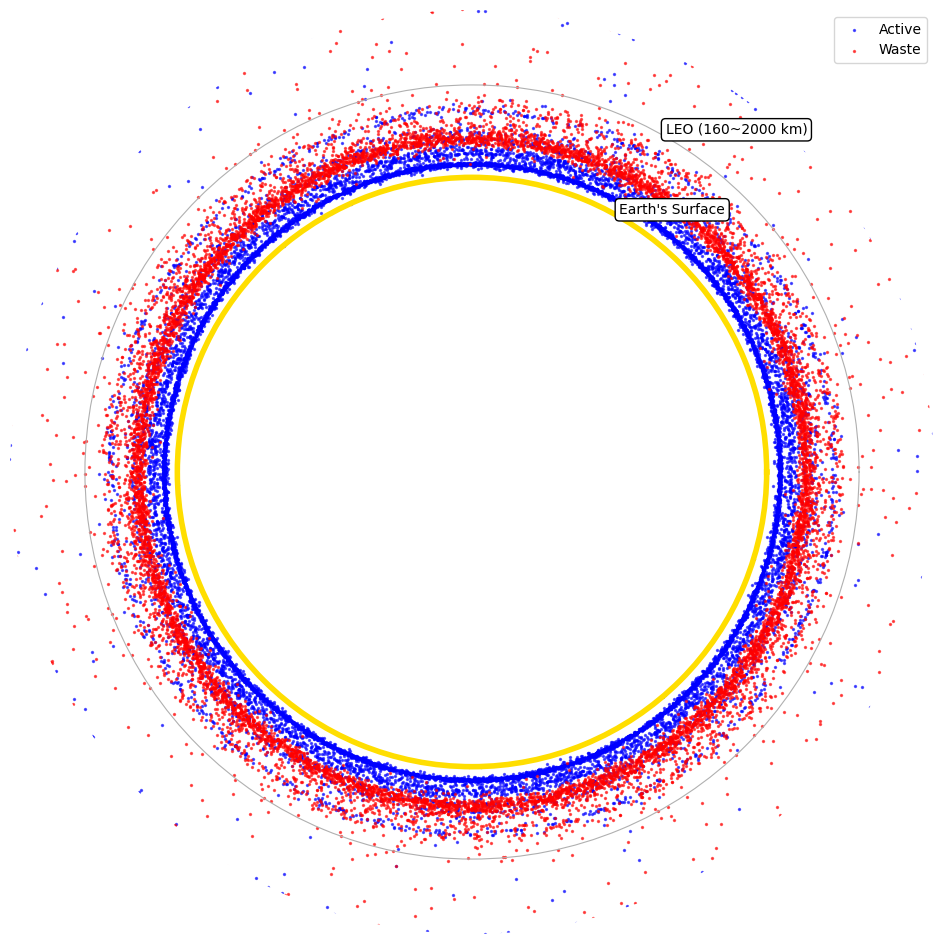

In [37]:
import numpy as np
import matplotlib.pyplot as plt

E_radius = 6378
# Define radius (r) as the satellite's average altitude + Earth’s radius
r1 = data_waste['average'] + E_radius
r2 = data_active['average'] + E_radius
theta1 = np.random.uniform(0, 2 * np.pi, size=len(r1))
theta2 = np.random.uniform(0, 2 * np.pi, size=len(r2))

# Generate random angles for scattering the points
theta = np.random.uniform(0, 2 * np.pi, size=len(r1))

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12))

ax.set_rlim(0, 10000)
# ax.set_yscale('log')

ax.spines['polar'].set_visible(False)

ax.scatter(theta2, r2, s=2, alpha=0.6, color='blue', label ="Active")
ax.scatter(theta1, r1, s=2, alpha=0.6, color='red', label ="Waste")

ax.grid(axis='x', visible=False)
# ax.grid(axis='y', visible=True) 


ax.set_xticks([])
ax.set_yticks([6378, 2000 + E_radius])

yticklabels = ax.set_yticklabels(["Earth's Surface", "LEO (160~2000 km)"])


# Set a background color for the label
for label in yticklabels:
    label.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    
ax.set_rlabel_position(60)

ax.yaxis.get_gridlines()[0].set_color('#FFDE00')
ax.yaxis.get_gridlines()[0].set_linewidth(4)
# ax.set_yticklabels(["Earth's Surface"])
ax.legend(loc='upper right')
plt.yticks(rotation = 45, ha = 'left')
# plt.savefig('satellite_plot.png', bbox_inches='tight', dpi=300)
plt.show()



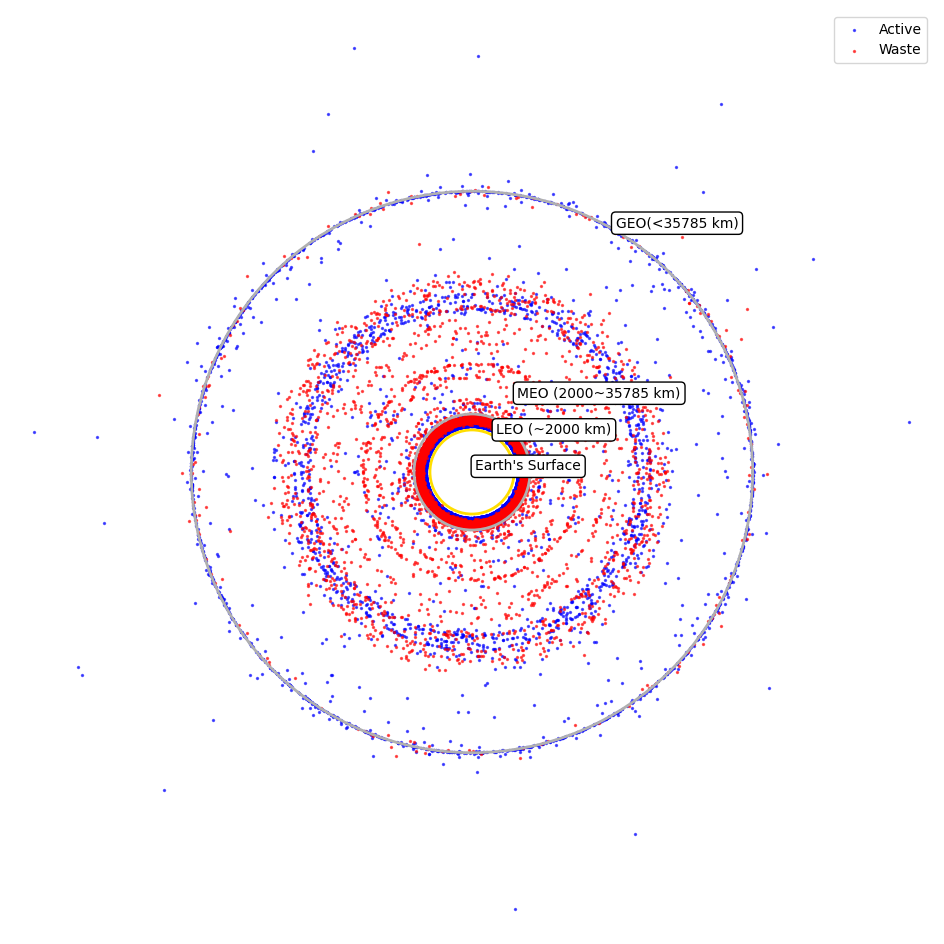

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
E_radius = 6800  # Approx. Earth radius in km

# Define radius (r) as the satellite's average altitude + Earth’s radius
r1 = data_waste['average'] + E_radius
r2 = data_active['average'] + E_radius
theta1 = np.random.uniform(0, 2 * np.pi, size=len(r1))
theta2 = np.random.uniform(0, 2 * np.pi, size=len(r2))

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12))
ax.set_rlim(0, 7000 + 8000)  # Radial limit
ax.spines['polar'].set_visible(False)

# Scatter satellite positions
ax.scatter(theta2, r2, s=2, alpha=0.6, color='blue', label="Active")
ax.scatter(theta1, r1, s=2, alpha=0.6, color='red', label="Waste")

# Hide angular grid lines
ax.grid(axis='x', visible=False)
ax.set_xticks([])

# Set radial ticks manually
ytick_vals = [0, 6378, 2000 + E_radius, 35785 + E_radius, 70085]
ax.set_yticks(ytick_vals)
ax.set_yticklabels(["", "", "", "", ""]) 

# Custom radial labels at an angle (e.g., 60 degrees)
labels = ["Earth's Surface", "LEO (~2000 km)", "MEO (2000~35785 km)", "GEO(<35785 km)", " " ]
label_angle = np.deg2rad(60)

for r, label in zip(ytick_vals[:-1], labels):
    if label == "MEO (2000~35785 km)":
        offset = 5000 # Larger offset only for LEO
    else:
        offset = 1000
    ax.text(
        label_angle,
        r + offset,
        label,
        fontsize=10,
        ha='left',
        va='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Adjust label angle position
ax.set_rlabel_position(60)

# Style specific gridlines
ax.yaxis.get_gridlines()[0].set_linewidth(2)
ax.yaxis.get_gridlines()[1].set_color('#FFDE00')
ax.yaxis.get_gridlines()[1].set_linewidth(2)
ax.yaxis.get_gridlines()[2].set_linewidth(2)
ax.yaxis.get_gridlines()[3].set_linewidth(2)
ax.yaxis.get_gridlines()[4].set_linewidth(0)  # Hide the outermost line

# Add legend
ax.legend(loc='upper right')

plt.show()


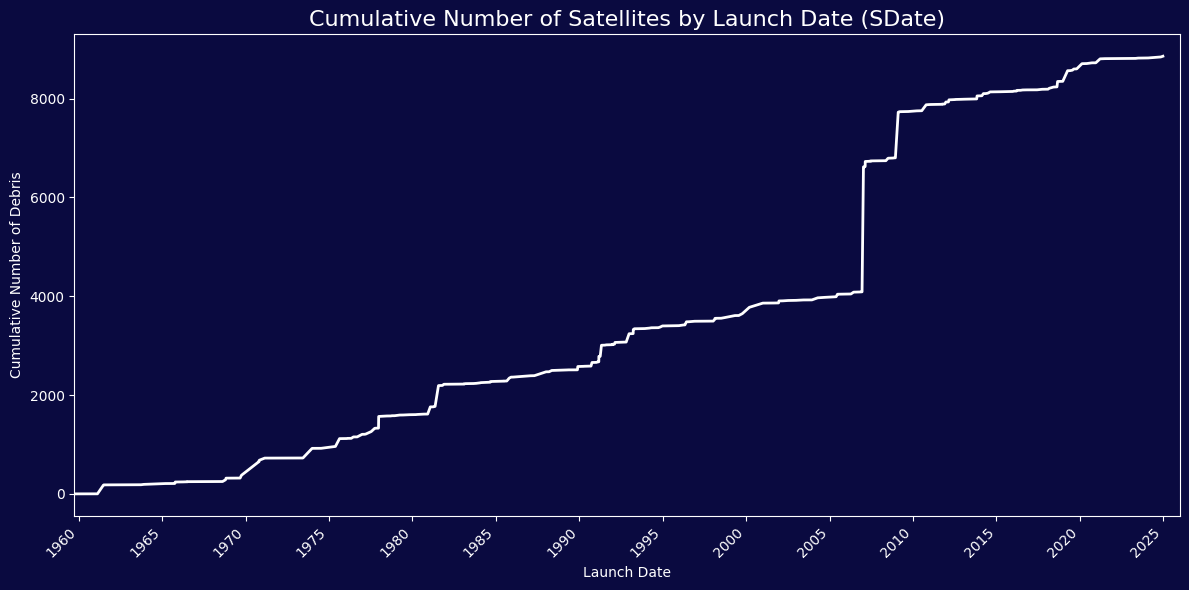

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_waste = data_waste.copy()
# Ensure 'SDate' is datetime
data_waste['SDate'] = pd.to_datetime(data_waste['SDate'], errors='coerce')

# Group by date and count number of launches per date
satellites_by_sdate = data_waste.groupby('SDate').size().reset_index(name='Count')

# Sort by date
satellites_by_sdate = satellites_by_sdate.sort_values('SDate')

# Calculate cumulative sum
satellites_by_sdate['Cumulative'] = satellites_by_sdate['Count'].cumsum()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(satellites_by_sdate['SDate'], satellites_by_sdate['Cumulative'], color='white', linewidth=2)  # Golden line

# Title and labels
ax.set_title('Cumulative Number of Satellites by Launch Date (SDate)', fontsize=16, color='white')
ax.set_xlabel('Launch Date', color='white')
ax.set_ylabel('Cumulative Number of Debris', color='white')

# Set the x-axis to start from 1957 and end at 2025
ax.set_xlim(pd.Timestamp('1959-10-01'), pd.Timestamp('2025-12-31'))

# Set 5-year interval on x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate date labels and set tick color
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white')
plt.setp(ax.get_yticklabels(), color='white')

# Set spine color to white
for spine in ax.spines.values():
    spine.set_color('white')

# Set tick color and line
ax.tick_params(colors='white')

# Grid and background
ax.grid(False)
fig.patch.set_facecolor('#0A0A40')  # Dark blue background for figure
ax.set_facecolor('#0A0A40')         # Dark blue background for plot area

plt.tight_layout()
plt.show()


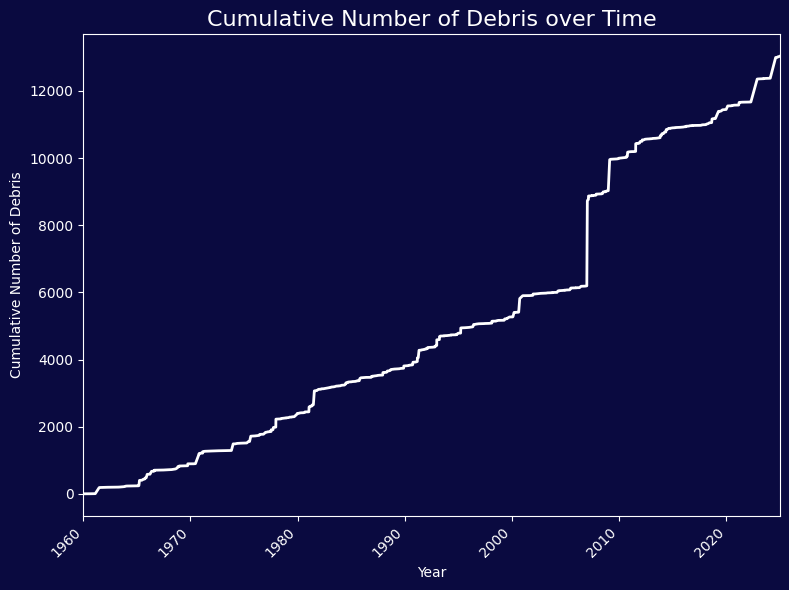

In [39]:
import matplotlib.dates as mdates
from ipywidgets import ToggleButtons, interact


# Make an explicit copy to avoid SettingWithCopyWarning
data_waste = data_waste.copy()

# Ensure 'SDate' and 'LDate' are datetime
data_waste['SDate'] = pd.to_datetime(data_waste['SDate'], errors='coerce')
data_waste['LDate'] = pd.to_datetime(data_waste['LDate'], errors='coerce')

# Use LDate where SDate is missing
data_waste['LaunchDate'] = data_waste['SDate'].fillna(data_waste['LDate'])

# Group by LaunchDate and count number of launches per date
satellites_by_date = data_waste.groupby('LaunchDate').size().reset_index(name='Count')

# Sort by LaunchDate
satellites_by_date = satellites_by_date.sort_values('LaunchDate')

# Calculate cumulative sum
satellites_by_date['Cumulative'] = satellites_by_date['Count'].cumsum()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(satellites_by_date['LaunchDate'], satellites_by_date['Cumulative'], color='white', linewidth=2)

# Title and labels
ax.set_title('Cumulative Number of Debris over Time', fontsize=16, color='white')
ax.set_xlabel('Year', color='white')
ax.set_ylabel('Cumulative Number of Debris', color='white')

# Set 5-year interval on x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('2025-01-01'))

# Rotate date labels and set tick color
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white')
plt.setp(ax.get_yticklabels(), color='white')

# Set spine color to white
for spine in ax.spines.values():
    spine.set_color('white')

# Set tick color and line
ax.tick_params(colors='white')

# Grid and background
ax.grid(False)
fig.patch.set_facecolor('#0A0A40')  # Dark blue background for figure
ax.set_facecolor('#0A0A40')         # Dark blue background for plot area

plt.tight_layout()
plt.show()

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from ipywidgets import ToggleButtons, interact
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100

# === Setup: clean dates for waste ===
data_waste = data_waste.copy()
data_waste['SDate'] = pd.to_datetime(data_waste['SDate'], errors='coerce')
data_waste['LDate'] = pd.to_datetime(data_waste['LDate'], errors='coerce')
data_waste['LaunchDate'] = data_waste['SDate'].fillna(data_waste['LDate'])

# === Setup: clean dates for active ===
data_active = data_active.copy()
data_active['SDate'] = pd.to_datetime(data_active['SDate'], errors='coerce')
data_active['LDate'] = pd.to_datetime(data_active['LDate'], errors='coerce')
data_active['LaunchDate'] = data_active['SDate'].fillna(data_active['LDate'])

# === Function to prepare cumulative data ===
def get_cumulative(df):
    df = df.dropna(subset=['LaunchDate'])
    df = df.groupby('LaunchDate').size().reset_index(name='Count')
    df = df.sort_values('LaunchDate')
    df['Cumulative'] = df['Count'].cumsum()
    return df

satellites_waste = get_cumulative(data_waste)
satellites_active = get_cumulative(data_active)

# === Interactive Plot Function ===
def plot_cumulative(selection):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if selection == 'Active' or selection == 'Both':
        ax.plot(satellites_active['LaunchDate'], satellites_active['Cumulative'],
                label='Active', color='#6EC6FF', linewidth=2)
    
    if selection == 'Debris' or selection == 'Both':
        ax.plot(satellites_waste['LaunchDate'], satellites_waste['Cumulative'],
                label='Debris', color='#FF6F61', linewidth=2)

    ax.set_title('Cumulative Number of Satellites Over Time', fontsize=16, color='white')
    ax.set_xlabel('Year', color='white')
    ax.set_ylabel('Cumulative Count', color='white')

    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('2025-01-01'))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', color='white')
    plt.setp(ax.get_yticklabels(), color='white')
    ax.tick_params(colors='white')

    for spine in ax.spines.values():
        spine.set_color('white')
    
    ax.grid(False)
    fig.patch.set_facecolor('#0A0A40')
    ax.set_facecolor('#0A0A40')

    ax.legend(facecolor='#0A0A40', labelcolor='white', loc = 'upper left')

    plt.tight_layout()
    plt.show()

# === Toggle Buttons ===
toggle = ToggleButtons(
    options=['Active', 'Debris', 'Both'],
    description='View:',
    style={'description_width': 'initial'},
    button_style='',
)

interact(plot_cumulative, selection=toggle)


interactive(children=(ToggleButtons(description='View:', options=('Active', 'Debris', 'Both'), style=ToggleBut…

<function __main__.plot_cumulative(selection)>

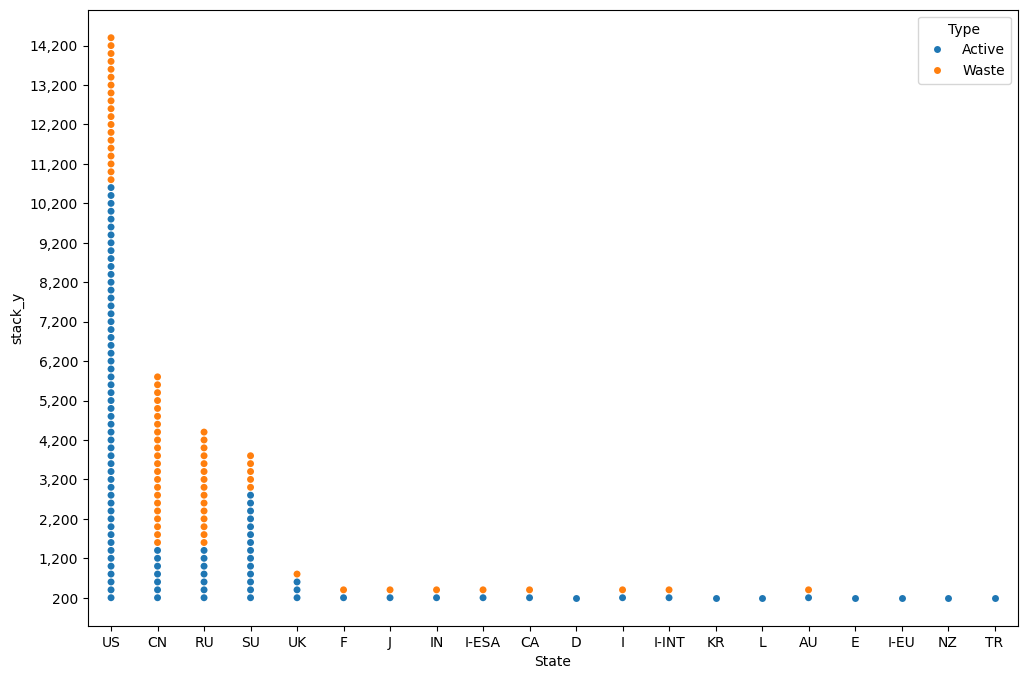

In [41]:
# Step 1: Count per country
active_counts = data_active['State'].value_counts().reset_index()
active_counts.columns = ['State', 'Active']

waste_counts = data_waste['State'].value_counts().reset_index()
waste_counts.columns = ['State', 'Waste']

# Step 2: Merge
merged = pd.merge(active_counts, waste_counts, on='State', how='outer').fillna(0)
merged['Total'] = merged['Active'] + merged['Waste']
top20 = merged.sort_values('Total', ascending=False).head(20)

# Step 3: Create long format with 1 dot per satellite
dot_rows = []

for _, row in top20.iterrows():
    if row['Active'] > 0:
        dot_rows += [{'State': row['State'], 'Type': 'Active'}] * max(1, int(row['Active'] // 200))
    if row['Waste'] > 0:
        dot_rows += [{'State': row['State'], 'Type': 'Waste'}] * max(1, int(row['Waste'] // 200))

dot_df = pd.DataFrame(dot_rows)

# Step 4: Compute stack position
dot_df['stack_y'] = dot_df.groupby('State').cumcount() + 1  # Add 1 to avoid 0 for log scale

# Step 5: Plot
plt.figure(figsize=(12, 8))
ax = sns.stripplot(
    data=dot_df,
    x='State',
    y='stack_y',
    hue='Type',
    dodge=False,
    jitter=False,
    palette={'Active': '#1f77b4', 'Waste': '#ff7f0e'},
    size=5
)


tick_interval = 5  # Change this for more/less granularity
max_y = dot_df['stack_y'].max()

# Generate tick positions and labels
yticks = list(range(1, max_y + 1, tick_interval))
yticklabels = [f"{tick * 200:,}" for tick in yticks]

plt.yticks(yticks, yticklabels)

plt.show()
# Step

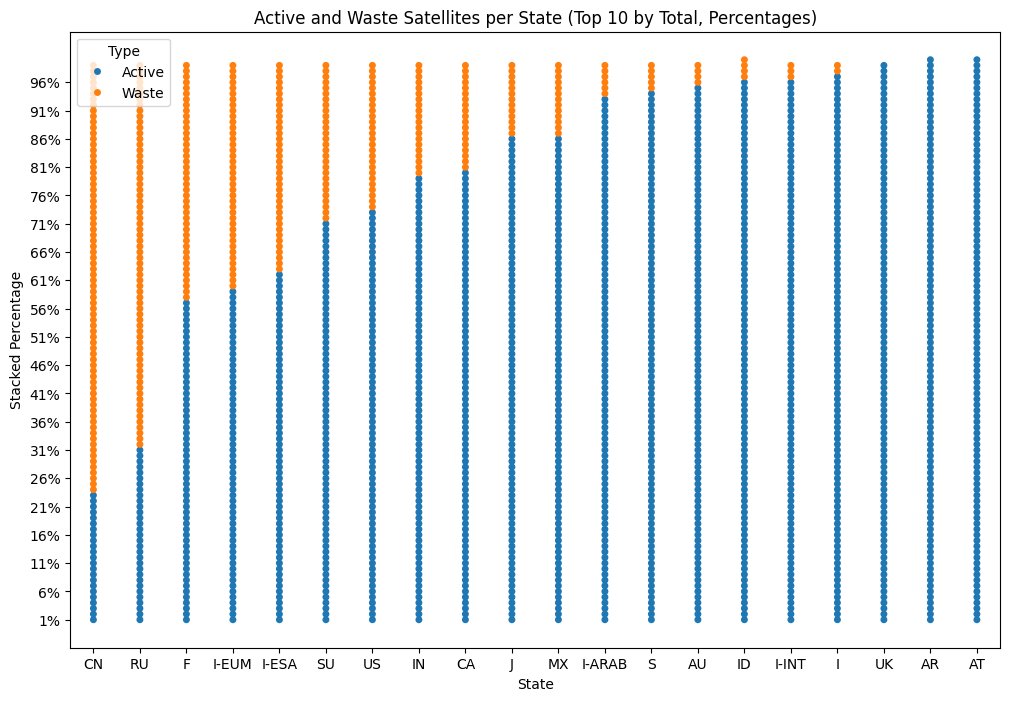

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Count per country (already done in your code)

# Step 2: Merge (already done in your code)
active_counts = data_active['State'].value_counts().reset_index()
active_counts.columns = ['State', 'Active']

waste_counts = data_waste['State'].value_counts().reset_index()
waste_counts.columns = ['State', 'Waste']

# Step 2: Merge
merged = pd.merge(active_counts, waste_counts, on='State', how='outer').fillna(0)
merged['Total'] = merged['Active'] + merged['Waste']
top20 = merged.sort_values('Waste', ascending=False)


# Step 3: Calculate percentages of Active and Waste relative to the total for each state
top20['Active_Percentage'] = top20['Active'] / top20['Total'] * 100
top20['Waste_Percentage'] = top20['Waste'] / top20['Total'] * 100

top20 = top20.sort_values('Waste_Percentage', ascending=False).head(20)


# Step 4: Create long format with 1 dot per satellite, but now based on percentage
dot_rows = []

for _, row in top20.iterrows():
    active_dots = int(row['Active_Percentage'])  # Number of dots for Active
    waste_dots = int(row['Waste_Percentage'])   # Number of dots for Waste
    
    # Add Active dots
    dot_rows += [{'State': row['State'], 'Type': 'Active'}] * active_dots
    
    # Add Waste dots
    dot_rows += [{'State': row['State'], 'Type': 'Waste'}] * waste_dots

dot_df = pd.DataFrame(dot_rows)

# Step 5: Compute stack position for each dot
dot_df['stack_y'] = dot_df.groupby('State').cumcount() + 1  # Add 1 to avoid 0 for log scale

# Step 6: Plot with the stacked dots
plt.figure(figsize=(12, 8))
ax = sns.stripplot(
    data=dot_df,
    x='State',
    y='stack_y',
    hue='Type',
    dodge=False,
    jitter=False,
    palette={'Active': '#1f77b4', 'Waste': '#ff7f0e'},
    size=5
)

# Set tick interval and generate labels
tick_interval = 5  # Adjust the interval for more/less granularity
max_y = dot_df['stack_y'].max()

# Generate tick positions and labels
yticks = list(range(1, max_y + 1, tick_interval))
yticklabels = [f"{tick * 1}%" for tick in yticks]

plt.yticks(yticks, yticklabels)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Stacked Percentage')
plt.title('Active and Waste Satellites per State (Top 10 by Total, Percentages)')

plt.show()


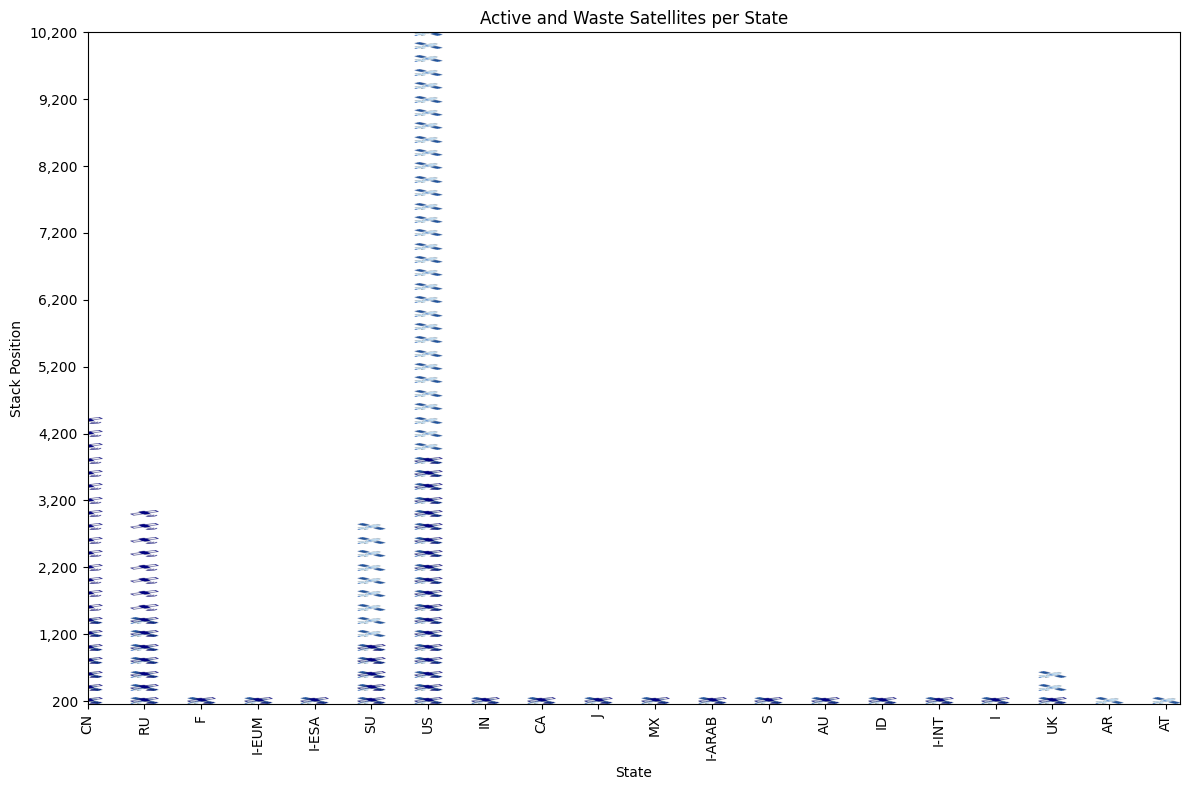

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

# Assuming 'top20' is already computed as in your provided code

# Step 5: Load images for "Active" and "Waste"
active_image = Image.open('sat.png')  # Replace with the path to your image
waste_image = Image.open('i.png')  # Replace with the path to your image

# Resize images to fit in the plot
active_image = active_image.resize((30, 30), Image.Resampling.LANCZOS)  # Resize with LANCZOS
waste_image = waste_image.resize((30, 30), Image.Resampling.LANCZOS)  # Resize with LANCZOS

# Step 6: Plot using images
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate through each state in top20 and place images
for idx, row in top20.iterrows():
    # Get the position of the state in the list
    state_pos = top20['State'].tolist().index(row['State'])
    
    # Plot 'Active' images
    if row['Active'] > 0:
        for i in range(max(1, int(row['Active'] // 200))):
            # Adjust the positioning of the image for active states
            y_position = i + 1  # Stack position for active satellites
            ax.imshow(active_image, aspect='auto', extent=(state_pos - 0.25, state_pos + 0.25, y_position - 0.25, y_position + 0.25))

    # Plot 'Waste' images
    if row['Waste'] > 0:
        for i in range(max(1, int(row['Waste'] // 200))):
            # Adjust the positioning of the image for waste states
            y_position = i + 1  # Stack position for waste satellites
            ax.imshow(waste_image, aspect='auto', extent=(state_pos - 0.25, state_pos + 0.25, y_position - 0.25, y_position + 0.25))

# Set plot labels and title
ax.set_xlabel('State')
ax.set_ylabel('Stack Position')
ax.set_title('Active and Waste Satellites per State')

# Set x-axis labels for the states
ax.set_xticks(np.arange(len(top20)))
ax.set_xticklabels(top20['State'], rotation=90)

# Generate tick positions and labels for y-axis
tick_interval = 5
max_y = top20['Active'].max() // 200 + 1  # Calculate max stack height based on the total number of satellites
yticks = list(range(1, max_y + 1, tick_interval))
yticklabels = [f"{tick * 200:,}" for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Tight layout to avoid any clipping
plt.tight_layout()

plt.show()


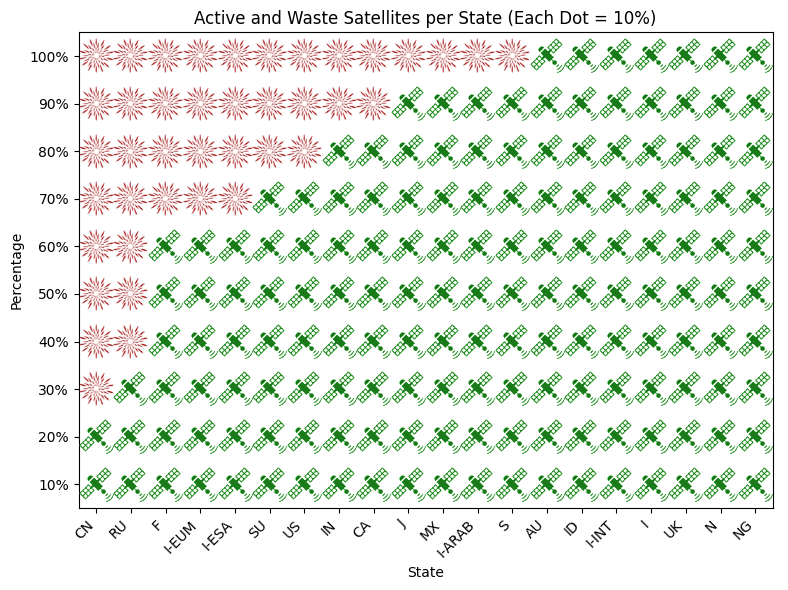

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Step 1–3: Already done
active_counts = data_active['State'].value_counts().reset_index()
active_counts.columns = ['State', 'Active']

waste_counts = data_waste['State'].value_counts().reset_index()
waste_counts.columns = ['State', 'Waste']

merged = pd.merge(active_counts, waste_counts, on='State', how='outer').fillna(0)
merged['Total'] = merged['Active'] + merged['Waste']
top20 = merged.sort_values('Waste', ascending=False).head(20)

top20['Active_Percentage'] = top20['Active'] / top20['Total'] * 100
top20['Waste_Percentage'] = top20['Waste'] / top20['Total'] * 100

top20 = top20.sort_values('Waste_Percentage', ascending=False)

# Step 4: Build dot-based representation (1 dot = 10%)
dot_rows = []

for _, row in top20.iterrows():
    active_dots = round(row['Active_Percentage'] / 10)
    waste_dots = round(row['Waste_Percentage'] / 10)

    # Add Active dots
    dot_rows += [{'State': row['State'], 'Type': 'Active'}] * active_dots
    # Add Waste dots
    dot_rows += [{'State': row['State'], 'Type': 'Waste'}] * waste_dots

dot_df = pd.DataFrame(dot_rows)

# Step 5: Stack position (1–10)
dot_df['stack_y'] = dot_df.groupby('State').cumcount() + 1

# Load images
img_active = mpimg.imread('b.png')  # Blue-style PNG
img_waste = mpimg.imread('a.png')   # Orange-style PNG

def create_image_marker(image, zoom=.5):
    return OffsetImage(image, zoom=zoom)

# Step 6: Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Map State to x position
state_to_x = {state: i for i, state in enumerate(dot_df['State'].unique())}

for _, row in dot_df.iterrows():
    x = state_to_x[row['State']]
    y = row['stack_y']
    img = img_active if row['Type'] == 'Active' else img_waste
    ab = AnnotationBbox(create_image_marker(img), (x, y), frameon=False)
    ax.add_artist(ab)

# Customize axes
ax.set_xticks(list(state_to_x.values()))
ax.set_xticklabels(list(state_to_x.keys()), rotation=45, ha='right')
ax.set_xlim(-0.5, len(state_to_x) - 0.5)

# Y-axis: 1–10 (representing 10%–100%)
ax.set_yticks(range(1, 11))
ax.set_yticklabels([f'{i*10}%' for i in range(1, 11)])
ax.set_ylim(0.5, 10.5)

# Labels
ax.set_xlabel('State')
ax.set_ylabel('Percentage')
ax.set_title('Active and Waste Satellites per State (Each Dot = 10%)')

plt.tight_layout()
plt.show()


In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load satellite dot images
img_active = mpimg.imread('b.png')  # Path to blue (active) icon
img_waste = mpimg.imread('a.png')   # Path to orange (waste) icon

def create_image_marker(image, zoom=0.5):
    return OffsetImage(image, zoom=zoom)

# Interactive plot function
def plot_dot_chart(group_by='State', top_n=20):
    if group_by not in data_active.columns or group_by not in data_waste.columns:
        print(f"Error: '{group_by}' column not found in the data.")
        return

    # Step 1: Group and count
    active_counts = data_active[group_by].value_counts().reset_index()
    active_counts.columns = [group_by, 'Active']

    waste_counts = data_waste[group_by].value_counts().reset_index()
    waste_counts.columns = [group_by, 'Waste']

    # Step 2: Merge
    merged = pd.merge(active_counts, waste_counts, on=group_by, how='outer').fillna(0)
    merged['Total'] = merged['Active'] + merged['Waste']

    # Step 3: Top N by Waste
    top_n = min(top_n, len(merged))  # Ensure top_n doesn't exceed available data
    top20 = merged.sort_values('Waste', ascending=False).head(top_n).copy()
    top20['Active_Percentage'] = top20['Active'] / top20['Total'] * 100
    top20['Waste_Percentage'] = top20['Waste'] / top20['Total'] * 100
    top20 = top20.sort_values('Waste_Percentage', ascending=False)

    # Step 4: Create dot entries (1 dot = 10%)
    dot_rows = []
    for _, row in top20.iterrows():
        active_dots = round(row['Active_Percentage'] / 10)
        waste_dots = round(row['Waste_Percentage'] / 10)

        dot_rows += [{group_by: row[group_by], 'Type': 'Active'}] * active_dots
        dot_rows += [{group_by: row[group_by], 'Type': 'Waste'}] * waste_dots

    dot_df = pd.DataFrame(dot_rows)
    if dot_df.empty:
        print("No data available for this grouping.")
        return

    dot_df['stack_y'] = dot_df.groupby(group_by).cumcount() + 1

    # Step 5: Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    label_order = dot_df[group_by].unique()
    label_to_x = {label: i for i, label in enumerate(label_order)}

    for _, row in dot_df.iterrows():
        x = label_to_x[row[group_by]]
        y = row['stack_y']
        img = img_active if row['Type'] == 'Active' else img_waste
        ab = AnnotationBbox(create_image_marker(img), (x, y), frameon=False)
        ax.add_artist(ab)

    # Customize axes
    ax.set_xticks(list(label_to_x.values()))
    ax.set_xticklabels(list(label_to_x.keys()), rotation=45, ha='right')
    ax.set_xlim(-0.5, len(label_to_x) - 0.5)
    ax.set_yticks(range(1, 11))
    ax.set_yticklabels([f'{i*10}%' for i in range(1, 11)])
    ax.set_ylim(0.5, 10.5)

    ax.set_xlabel(group_by)
    ax.set_ylabel('Percentage')
    ax.set_title(f'Active and Waste Satellites per {group_by} (Each Dot = 10%)')

    plt.tight_layout()
    plt.show()

# Toggle buttons for interactivity
toggle = widgets.ToggleButtons(
    options=['State', 'Owner'],
    description='Group by:',
    button_style='info'
)

# Slider widget to control the number of top rows to display
slider = widgets.IntSlider(
    value=20,
    min=5,
    max=25,
    step=1,
    description='Top N:',
    continuous_update=False
)


widgets.interact(plot_dot_chart, group_by=toggle, top_n=slider)

interactive(children=(ToggleButtons(button_style='info', description='Group by:', options=('State', 'Owner'), …

<function __main__.plot_dot_chart(group_by='State', top_n=20)>